In [2]:
import torch
import pandas as pd
import numpy as np
import random 
import math
from tqdm import tqdm
from IPython.display import clear_output
import itertools 
import operator
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LinearLocator, AutoMinorLocator

import seaborn as sns
from scipy import stats
from copy import deepcopy
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from statsmodels.stats.multitest import multipletests


h:\z\.conda\envs\data\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
h:\z\.conda\envs\data\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
h:\z\.conda\envs\data\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
## analysis for version 1.33
v = "4.02"#"1.33"
subset_versions = ["9.0" , "9.11", "9.21"]
save_path = r"O:/projekter/PY000017_D/analysis/plots/%s/" %v
data_path = r"O:/projekter/PY000017_D/logs/v15/pre_training/version_%s/00014/token_embeddings/tensors.tsv"
vocab_path = r"K:\22SSI\Germans\processed\vocab\global_set\result.tsv"
paths = [data_path %sv for sv in subset_versions]
vocab = pd.read_csv(vocab_path, sep="\t").set_index("ID")


In [4]:
def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

In [5]:
###
def get_random_pairs(numbers:list, num_pairs: int): 
    """Generate random integer pairs"""
    random.seed(0)
    pairs = list(itertools.combinations(numbers, 2)) 
    random.shuffle(pairs)
    pairs = pairs[:num_pairs]
    return pairs 

In [6]:
### cosine distances
def dot_product2(v1, v2):
    return sum(map(operator.mul, v1, v2))
    
def vector_cos(v1, v2):
    prod = dot_product2(v1, v2)
    len1 = math.sqrt(dot_product2(v1, v1))
    len2 = math.sqrt(dot_product2(v2, v2))
    return prod / (len1 * len2)

In [7]:
def pairwise_distances(x, pairs):
    euclidean_dist = []
    cosine_dist = []
    for pair in pairs: 
        a = x[pair[0]]
        b = x[pair[1]]
        euclidean_dist.append(np.linalg.norm(a-b))
        cosine_dist.append(vector_cos(a,b))
    return euclidean_dist, cosine_dist
    

In [8]:
vocab_size = 2043
pairs = get_random_pairs([i for i in range(7, vocab_size)], num_pairs = 10000)

In [9]:
np.random.seed(0)
embeddings = list()
for path in paths:
    e = pd.read_csv(path, sep="\t", header=None).values
    mu = e.sum(0) / (vocab.shape[0] - 6)
    e= e - mu
    embeddings.append(e)
permuted = deepcopy(embeddings[0])
for i in range(e.shape[1]):
    permuted[:,i] = np.random.permutation(permuted[:,i])
randome = np.random.normal(permuted.mean(), permuted.std(), size=permuted.shape)

## Robustness

In [59]:
eucl_1, cos_1 = pairwise_distances(embeddings[0], pairs)
eucl_2, cos_2 = pairwise_distances(embeddings[1], pairs)
eucl_3, cos_3 = pairwise_distances(embeddings[2], pairs)
eucl_r, cos_r = pairwise_distances(randome, pairs)
eucl_p, cos_p = pairwise_distances(permuted, pairs)

In [60]:
max_points = 500

In [61]:
def outlier_detection(coefs, x, y, max_accept_deviation: int = 1):
    fn = np.poly1d(coefs)
    residual = np.abs(y - fn(x))
    return max_accept_deviation < residual

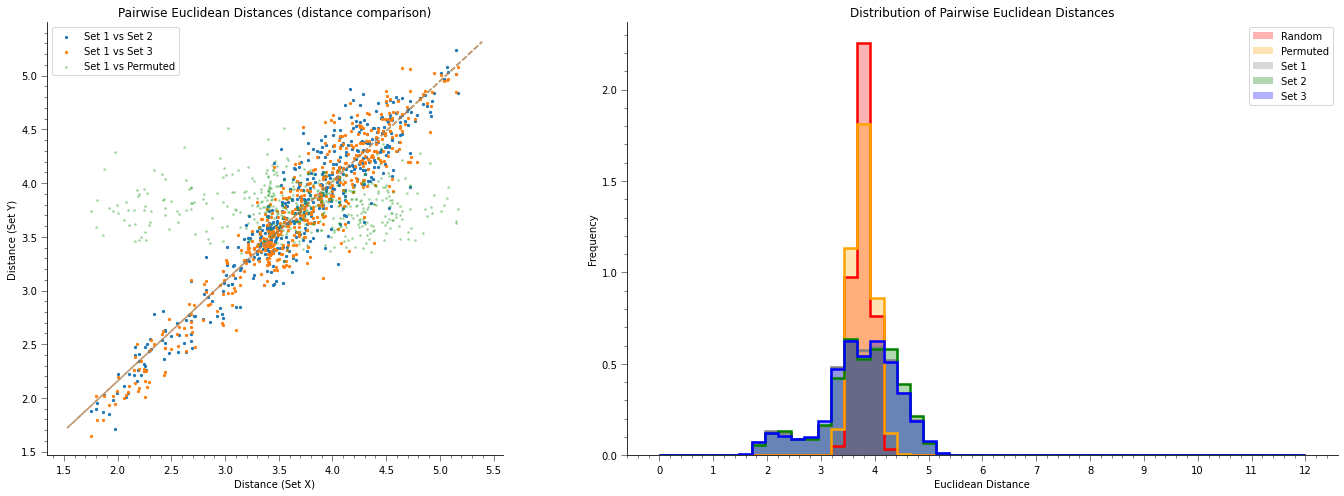

In [62]:
### Linear fit
coef_1 = np.polyfit(eucl_1[:max_points], eucl_2[:max_points], 1)
poly_1_fn = np.poly1d(coef_1)
### 
coef_2 = np.polyfit(eucl_1[:max_points], eucl_3[:max_points], 1)
poly_2_fn = np.poly1d(coef_1)

#####
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].set_title("Pairwise Euclidean Distances (distance comparison)")
ax[0].set_xlabel("Distance (Set X)")
ax[0].set_ylabel("Distance (Set Y)")
ax[0].scatter(eucl_1[:max_points], eucl_2[:max_points], s=5)
ax[0].scatter(eucl_1[:max_points], eucl_3[:max_points], s=5)

ax[0].scatter(eucl_1[:max_points], eucl_p[:max_points], s=5, alpha=0.3, marker="*")
ax[0].legend(["Set 1 vs Set 2", "Set 1 vs Set 3", "Set 1 vs Permuted"])

# for i in range(max_points):
#     if outlier_detection(coef_1, eucl_1[i], eucl_2[i], np.std(eucl_1) ):
#          ax[0].annotate(str(pairs[i]), (eucl_1[i] + np.random.uniform(low=-0.05, high=0.05), eucl_2[i] +  np.random.uniform(low=0.001, high=0.05)))
#     if outlier_detection(coef_2, eucl_1[i], eucl_3[i], np.std(eucl_1) ):
#          ax[0].annotate(str(pairs[i]), (eucl_1[i] + np.random.uniform(low=-0.05, high=0.05), eucl_3[i] +  np.random.uniform(low=0.001, high=0.05)))
        

ax[0].plot(eucl_1, poly_1_fn(eucl_1), linestyle="dashed", alpha = 0.5)
ax[0].plot(eucl_1, poly_2_fn(eucl_1), linestyle="dashed", alpha = 0.5)
ax[0].axis("scaled")

ax[0].tick_params(axis= "both", which="major", width=1, length = 6, direction="out", color="gray")
ax[0].tick_params(axis= "both", which="minor", width=1, length =3, direction="out", color="gray")

ax[0].yaxis.set_major_locator(MultipleLocator(0.5))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))

ax[0].xaxis.set_major_locator(MultipleLocator(0.5))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))


ax[1].set_title("Distribution of Pairwise Euclidean Distances")
ax[1].set_xlabel("Euclidean Distance")
ax[1].set_ylabel("Frequency")
bins = np.linspace(start=0, stop=12, num=50)

ax[1].hist(eucl_r, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="red")
ax[1].hist(eucl_p, density = True, bins=bins, histtype="stepfilled", alpha= 0.3, color="orange")
ax[1].hist(eucl_1, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="gray")
ax[1].hist(eucl_2, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="green")
ax[1].hist(eucl_3, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="blue")

ax[1].hist(eucl_r, density = True, bins=bins, histtype="step", linewidth=2.5, color="red")
ax[1].hist(eucl_p, density = True, bins=bins, histtype="step", linewidth=2.5, color="orange")
ax[1].hist(eucl_1, density = True, bins=bins, histtype="step", linewidth=2.5, color="gray")
ax[1].hist(eucl_2, density = True, bins=bins, histtype="step", linewidth=2.5, color="green")
ax[1].hist(eucl_3, density = True, bins=bins, histtype="step", linewidth=2.5, color="blue")

ax[1].legend([ "Random", "Permuted", "Set 1", "Set 2", "Set 3"])

ax[1].tick_params(axis= "both", which="major", width=1, length = 6, direction="out", color="gray")
ax[1].tick_params(axis= "both", which="minor", width=1, length =3, direction="out", color="gray")

ax[1].yaxis.set_major_locator(MultipleLocator(0.5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))

ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(5))

plt.tight_layout()
sns.despine()
plt.savefig(save_path + "/life_emb_pairwise_euclidean.svg", format="svg")
plt.show()

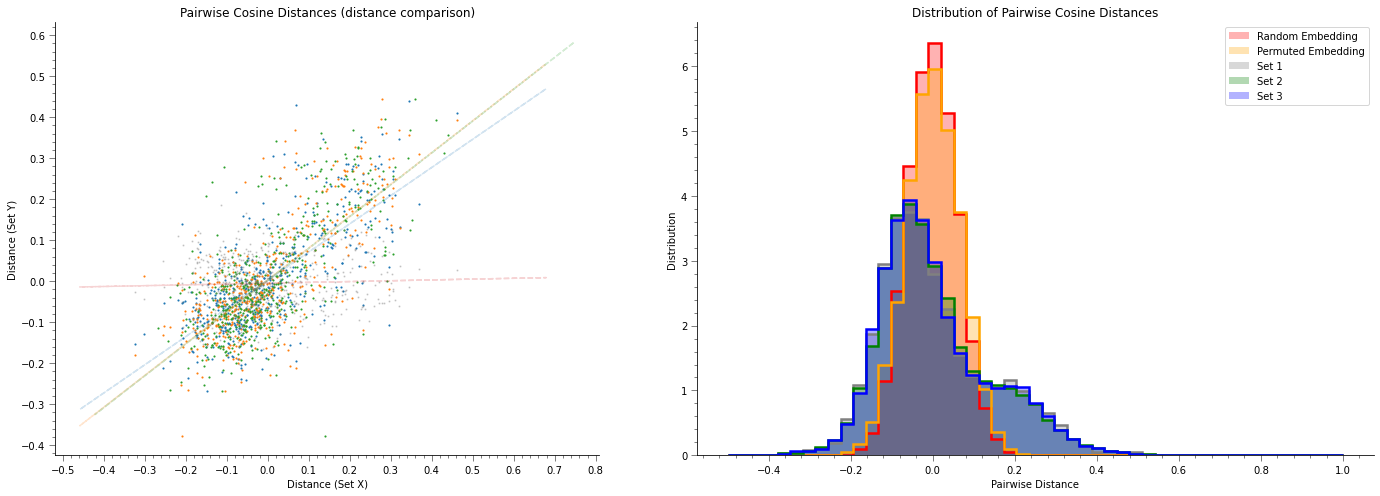

In [63]:
### Linear fit
coef_1 = np.polyfit(cos_1[:max_points], cos_2[:max_points], 1)
poly_1_fn = np.poly1d(coef_1)
### 
coef_2 = np.polyfit(cos_1[:max_points], cos_3[:max_points], 1)
poly_2_fn = np.poly1d(coef_2)
#####
coef_3 = np.polyfit(cos_2[:max_points], cos_3[:max_points], 1)
poly_3_fn = np.poly1d(coef_3)

#####
coef_4 = np.polyfit(cos_1[:max_points], cos_p[:max_points], 1)
poly_4_fn = np.poly1d(coef_4)


fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].set_title("Pairwise Cosine Distances (distance comparison)")
ax[0].set_xlabel("Distance (Set X)")
ax[0].set_ylabel("Distance (Set Y)")
ax[0].scatter(cos_1[:max_points], cos_2[:max_points], marker=".", s=5)
ax[0].scatter(cos_1[:max_points], cos_3[:max_points], marker=".", s=5)
ax[0].scatter(cos_2[:max_points], cos_3[:max_points], marker=".", s=5)
ax[0].scatter(cos_1[:max_points], cos_p[:max_points], alpha=0.3, s=5, marker=".", color="grey")
plt.legend(["Set 1 vs Set 2", "Set 1 vs Set 3", "Set 2 vs Set 3", "Set 1 vs Permuted"])

#for i in range(max_points):
#    if outlier_detection(coef_1, cos_1[i], cos_2[i], np.std(cos_1) ):
#         plt.annotate(str(pairs[i]), (cos_1[i] + np.random.uniform(low=-0.02, high=0.02), cos_2[i] + + np.random.uniform(low=-0.02, high=0.02)))
#    elif outlier_detection(coef_2, cos_1[i], cos_3[i], np.std(cos_1) ):
#         plt.annotate(str(pairs[i]), (cos_1[i] + np.random.uniform(low=-0.02, high=0.02), cos_3[i] + + np.random.uniform(low=-0.02, high=0.02)))
#    elif outlier_detection(coef_3, cos_2[i], cos_3[i], np.std(cos_2) ):
#         plt.annotate(str(pairs[i]), (cos_2[i] + np.random.uniform(low=-0.02, high=0.02), cos_3[i] + + np.random.uniform(low=-0.02, high=0.02)))
        

ax[0].plot(cos_1, poly_1_fn(cos_1), linestyle="dashed", alpha = 0.2)
ax[0].plot(cos_1, poly_2_fn(cos_1), linestyle="dashed", alpha = 0.2)
ax[0].plot(cos_2, poly_3_fn(cos_2), linestyle="dashed", alpha = 0.2)
ax[0].plot(cos_1, poly_4_fn(cos_1), linestyle="dashed", alpha = 0.2)
ax[0].axis("scaled")


ax[1].set_title("Distribution of Pairwise Cosine Distances")
ax[1].set_xlabel("Pairwise Distance")
ax[1].set_ylabel("Distribution")

ax[0].tick_params(axis= "both", which="major", width=1, length = 6, direction="out", color="gray")
ax[0].tick_params(axis= "both", which="minor", width=1, length =3, direction="out", color="gray")

ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))

ax[0].xaxis.set_major_locator(MultipleLocator(0.1))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))

bins = np.linspace(start=-0.5, stop=1, num=50)

ax[1].hist(cos_r, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="red")
ax[1].hist(cos_p,  density = True, bins=bins, histtype="stepfilled", alpha= 0.3, color="orange")
ax[1].hist(cos_1, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="gray")
ax[1].hist(cos_2, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="green")
ax[1].hist(cos_3, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="blue")


ax[1].hist(cos_r, density = True, bins=bins, histtype="step", linewidth=2.5, color="red")
ax[1].hist(cos_p,  density = True, bins=bins, histtype="step", linewidth=2.5, color="orange")
ax[1].hist(cos_1, density = True, bins=bins, histtype="step", linewidth=2.5, color="gray")
ax[1].hist(cos_2, density = True, bins=bins, histtype="step", linewidth=2.5, color="green")
ax[1].hist(cos_3, density = True, bins=bins, histtype="step", linewidth=2.5, color="blue")

ax[1].legend(["Random Embedding", "Permuted Embedding", "Set 1", "Set 2", "Set 3"])

ax[1].tick_params(axis= "both", which="major", width=1, length = 6, direction="out", color="gray")
ax[1].tick_params(axis= "both", which="minor", width=1, length =3, direction="out", color="gray")

ax[1].yaxis.set_major_locator(MultipleLocator(1))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))

ax[1].xaxis.set_major_locator(MultipleLocator(0.2))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(5))

plt.tight_layout()
sns.despine()
plt.savefig(save_path + "/life_emb_pairwise_cosine.svg", format="svg")
plt.show()

In [64]:
# ## Difference 
# plt.figure(figsize=(30,10))
# plt.title("Distribution of (Random) Pairwise Cosine Differences")
# plt.xlabel("Pairwise L2 Difference of Cosine Distance")

# bins = np.linspace(start=0, stop=1.4, num=50)
# plt.hist( (np.array(cos_1) - np.array(cos_2))**2, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="r")
# plt.hist( (np.array(cos_1) - np.array(cos_r))**2, density = True, bins=bins, histtype="stepfilled", alpha= 0.3, color="b")
# plt.hist( (np.array(cos_1) - np.array(cos_p))**2, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="y")

# plt.hist( (np.array(cos_1) - np.array(cos_2))**2, density = True, bins=bins, histtype="step", linewidth=2.5, color="r")
# plt.hist( (np.array(cos_1) - np.array(cos_r))**2, density = True, bins=bins, histtype="step", linewidth=2.5, color="b")
# plt.hist( (np.array(cos_1) - np.array(cos_p))**2, density = True, bins=bins, histtype="step", linewidth=2.5, color="y")

# plt.legend(["Set 1 vs Set 2", "Set 1 vs Random", "Set 1 vs Permuted Embedding"])
# plt.tight_layout()
# sns.despine()
# plt.savefig(save_path + "/life_emb_distr_pairwise_euclidean.svg", format="svg")
# plt.show()

### Permutation Test (SStatistical Significance)
Comparing:c1 -> c2, c3, cr, cp

In [10]:
c1 = cosine_distances(embeddings[0])
c2 = cosine_distances(embeddings[1])
c3 = cosine_distances(embeddings[2])
cp = cosine_distances(permuted)
cr = cosine_distances(randome)

In [12]:
print("%.4f" %stats.spearmanr(upper(c1), upper(c2)).correlation, 
      "%.4f" %stats.spearmanr(upper(c1), upper(c3)).correlation,
      "%.4f" %stats.spearmanr(upper(c2), upper(c3)).correlation,
      "%.4f" % stats.spearmanr(upper(c1), upper(cp)).correlation,
      "%.4f" % stats.spearmanr(upper(c1), upper(cr)).correlation)

0.6683 0.6603 0.6615 -0.0007 -0.0002


In [43]:
def permutation_test(a, b, n_iter: int = 5000, hyp="greater"):
    """Nonparametric permutation testing Monte Carlo"""
    m1 = pd.DataFrame(a)
    m2 = pd.DataFrame(b)
    np.random.seed(0)
    rhos = []
    true_rho, _ = stats.spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for i in tqdm(range(n_iter)):
        np.random.shuffle(m_ids) # shuffle list 
        r, _ = stats.spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
        rhos.append(r)
    if hyp == "greater":
        return (np.sum(true_rho <= rhos)+1)/(n_iter+1) 
    elif hyp == "less":
        return (np.sum(true_rho >= rhos)+1)/(n_iter+1)
    elif hyp=="two-sided":
        return (np.sum(np.abs(true_rho <= np.abs(rhos)))+1)/(n_iter+1), rhos # two-tailed test

In [44]:
clear_output()
print("1 vs 2")
p12 = permutation_test(c1,c2)
clear_output()
print(p12)
print("1 vs 3")
p13 = permutation_test(c1,c3)
clear_output()
print(p12, p13)
print("2 vs 3")
p23 = permutation_test(c2,c3)
clear_output()
print(p12, p13, p23)
print("1 vs R")
p1r = permutation_test(c1,cr)
clear_output()
print(p12, p13, p23, p1r)
print("1 vs P")
p1p = permutation_test(c1,cp)
print(p12, p13, p23, p1r, p1p)

0.0001999600079984003 0.0001999600079984003 0.0001999600079984003 0.6122775444911018
1 vs P


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:34:33<00:00,  1.13s/it]

0.0001999600079984003 0.0001999600079984003 0.0001999600079984003 0.6122775444911018 0.8520295940811837


In [45]:
p_vals = [p12, p13, p23, p1r, p1p]
p_vals 

[0.0001999600079984003,
 0.0001999600079984003,
 0.0001999600079984003,
 0.6122775444911018,
 0.8520295940811837]

In [46]:
labels = ["1 vs 2", "1 vs 3", "2 vs 3", "1 vs R", "1 vs P"]
reject, p_corr, alpha_sidak, alpha_bf  = multipletests(p_vals, method="fdr_bh")
for i in range(len(labels)):
    print("%s (p = %.6f) || Reject: %s" %(labels[i], p_corr[i], reject[i]))

1 vs 2 (p = 0.000333) || Reject: True
1 vs 3 (p = 0.000333) || Reject: True
2 vs 3 (p = 0.000333) || Reject: True
1 vs R (p = 0.765347) || Reject: False
1 vs P (p = 0.852030) || Reject: False


In [75]:
#### ADDITIONAL TESTS

e_add = []
paths = [r"O:/projekter/PY000017_D/logs/v15/pre_training/version_1.33/00029/token_embeddings/tensors.tsv",
         r"O:/projekter/PY000017_D/logs/v15/pre_training/version_6.0/00029/token_embeddings/tensors.tsv", 
         r"O:/projekter/PY000017_D/logs/v15/pre_training/version_6.1/00029/token_embeddings/tensors.tsv",
         r"O:/projekter/PY000017_D/logs/v15/pre_training/version_6.2/00029/token_embeddings/tensors.tsv",
         r"O:/projekter/PY000017_D/logs/v15/pre_training/version_6.3/00029/token_embeddings/tensors.tsv",

        ]
for path in paths:
    e = pd.read_csv(path, sep="\t", header=None).values
    mu = e.sum(0) / (vocab.shape[0] - 6)
    e_add.append(e - mu)
c_orig = cosine_distances(e_add[0])
c_b1   = cosine_distances(e_add[1])
c_b2   = cosine_distances(e_add[2])
c_b3   = cosine_distances(e_add[3])
c_b4   = cosine_distances(e_add[-1])

In [77]:
p_vals_b = [permutation_test(c_orig, c_b1), permutation_test(c_orig, c_b2), permutation_test(c_orig, c_b3), permutation_test(c_orig, c_b4)]
print(p_vals_b)
#stats.spearmanr(upper(c_orig), upper(c_b1))

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:32:35<00:00,  1.11s/it]

[0.0001999600079984003, 0.0001999600079984003, 0.0001999600079984003, 0.0001999600079984003]


In [76]:
corr = [stats.spearmanr(upper(c_orig), upper(c_b1)).correlation, 
        stats.spearmanr(upper(c_orig), upper(c_b2)).correlation,
        stats.spearmanr(upper(c_orig), upper(c_b3)).correlation,
        stats.spearmanr(upper(c_orig), upper(c_b4)).correlation]
corr

[0.6721401390003724,
 0.6907955916735513,
 0.6874137424821768,
 0.6505890114371915]

In [ ]:
reject, p_corr, alpha_sidak, alpha_bf  = multipletests(p_vals_b, method="fdr_bh")
labels = [ "b1", "b2", "b3", "b4"]
for i in range(len(labels)):
    print("%s corr: %.3f (p = %.4f) || Reject: %s" %(labels[i], corr[i], p_corr[i], reject[i]))

b1 corr: 0.000 (p = 0.000200) || Reject: True
b2 corr: 0.000 (p = 0.000200) || Reject: True
b3 corr: 0.000 (p = 0.000200) || Reject: True
b4 corr: 0.000 (p = 0.000200) || Reject: True


In [95]:
from glob import glob

In [102]:
orig_paths = glob("O:/projekter/PY000017_D/logs/v15/pre_training/version_1.33/*/token_embeddings/tensors.tsv")
orig_add = []
for path in orig_paths:
    e = pd.read_csv(path, sep="\t", header=None).values
    mu = e.sum(0) / (vocab.shape[0] - 6)
    orig_add.append(e - mu)
    
corr_list = []
for i in range(len(orig_paths)):
    dl = cosine_distances(orig_add[-1])
    dn = cosine_distances(orig_add[i])
    corr_list.append(stats.spearmanr(upper(dl), upper(dn)).correlation)
    

In [107]:
corr_list

[0.5885950301495029,
 0.6899246667063094,
 0.7717093630031147,
 0.8472110794580682,
 0.9078139840205627,
 0.9545684932534627,
 0.9840344773952057,
 0.9966176157523435,
 0.9983538451078366,
 1.0]

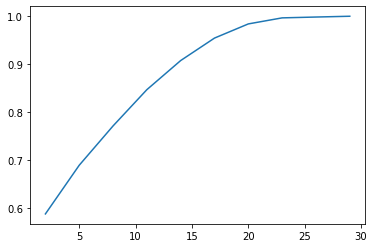

In [106]:
plt.plot(  [2,5,8,11,14,17,20,23,26,29], corr_list)

In [109]:
hc = ['HH','EM','EX','AG','CO','OP', "SDO", "SVOa", "RISK", "CRTi", "CRTr"] + ['HEXACO_consc3',
 'HEXACO_agree7',
 'HEXACO_open8R',
 'HEXACO_agree8',
 'HEXACO_extra9R',
 'HEXACO_consc9R',
 'HEXACO_agree4',
 'HEXACO_emo7R',
 'HEXACO_extra8',
 'HEXACO_agree1R',
 'HEXACO_open6',
 'HEXACO_extra5',
 'HEXACO_open10R',
 'HEXACO_open3',
 'HEXACO_open5R',
 'HEXACO_agree9R',
 'HEXACO_emo8',
 'HEXACO_hh4',
 'HEXACO_agree5',
 'HEXACO_agree6R',
 'HEXACO_open9',
 'HEXACO_extra10R',
 'HEXACO_consc8R',
 'HEXACO_agree10',
 'HEXACO_consc5R',
 'HEXACO_extra7',
 'HEXACO_emo3',
 'HEXACO_hh3R',
 'HEXACO_consc2R',
 'HEXACO_consc10R',
 'HEXACO_extra2R',
 'HEXACO_emo1',
 'HEXACO_extra6',
 'HEXACO_agree2',
 'HEXACO_emo5',
 'HEXACO_extra4',
 'HEXACO_hh8',
 'HEXACO_consc7',
 'HEXACO_hh7R',
 'HEXACO_consc6',
 'HEXACO_emo10R',
 'HEXACO_hh2',
 'HEXACO_hh5R',
 'HEXACO_consc4R',
 'HEXACO_hh1R',
 'HEXACO_emo6',
 'HEXACO_hh9R',
 'HEXACO_emo2R',
 'HEXACO_extra3R',
 'HEXACO_open7R',
 'HEXACO_emo9',
 'HEXACO_hh6R',
 'HEXACO_open4',
 'HEXACO_agree3R',
 'HEXACO_hh10',
 'HEXACO_emo4R',
 'HEXACO_open2',
 'HEXACO_open1R',
 'HEXACO_extra1',
 'HEXACO_consc1']

In [112]:
for i, col in enumerate(hc):
    if "extra" in col:
        print(i, col)

15 HEXACO_extra9R
19 HEXACO_extra8
22 HEXACO_extra5
32 HEXACO_extra10R
36 HEXACO_extra7
41 HEXACO_extra2R
43 HEXACO_extra6
46 HEXACO_extra4
59 HEXACO_extra3R
69 HEXACO_extra1


In [149]:
    def cosine( x, y, eps=1e-5):
        d = torch.nan_to_num(torch.sqrt(torch.pow(x,2) + torch.pow(y,2)),nan=eps)
        return torch.nan_to_num(torch.clamp(x/d, min=eps, max=1.), nan=eps)

In [170]:
l = []
ll =   []
for i in range(1, 100):
    ii = i
    x = torch.Tensor([ii])
    y = torch.Tensor([100-ii])
    l.append(1 - cosine(x,y).numpy())
    ll.append(cosine(x,y).numpy())

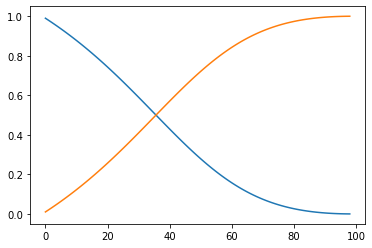

In [171]:
plt.plot(l)
plt.plot(ll)

In [204]:
delta = 3.
x = torch.tensor([[0., 1., 2.], [3.,4.,5]])

In [205]:
def huber(x, delta:float = 3.):
    return torch.where(
        x< delta,
        0.5 * torch.pow(x, 3),
        delta * (x - 0.5 * delta)
    )

tensor([[ 0.0000,  0.5000,  4.0000],
        [ 4.5000,  7.5000, 10.5000]])